In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
!pip install import-ipynb
import import_ipynb
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from functools import reduce  
from pyspark.sql import DataFrame

spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT
###!@0 END INIT ENVIRONMENT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import all the code required
#%cd /content/drive/Shareddrives/DataEngineeringProject/

/content/drive/Shareddrives/DataEngineeringProject


In [ ]:
%reload_ext autoreload
%autoreload 2
from sourabh import *
from Shilpa import *
from Syama import *

In [ ]:
States = ["A", "B", "C"]

#basePath = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/"
basePath = "SouthDistricts/"
"""
  Method to read the data for a particular state on particular time period (current default : 2019_2020)
  Drops all the unnecessary columns and replaces nulls with 0 and returns the data
"""
def readAllDataForState(state, year="2019_2020"):
  path = basePath + year + "/" + state + "/*.csv"
  data = spark.read.option("header",True).option("inferSchema",True).csv(path)
  colsNotRequired = ("Building", "Boundary_Wall", "Single_Class_Room",\
                     "Separate_Room_for_Headmaster", "Land_Available", "Electricity",\
                      "Furniture", "Librarian", "Boy_Toilet", "Girl_Toilet", "Drinking_Water")
  data.drop(*colsNotRequired)
  data.na.fill(0)
  return data

**Qualitative Analysis**


**Q1 Validation**

In [ ]:

def generateSyntheticDataQ1():
  requiredFields = ["State_Name", "District_Name", "Location", "School_Management_Name", "School_Management_Id", "Total_Number_of_Schools", "Academic_Year"]

  realData = readAllDataForState("Karnataka") #This is just to get the column names/schema/counts, could be any state
  schema = realData.schema
  pds = realData.toPandas()
  syntheticData = spark.createDataFrame(pds, schema=schema)

  managementIds = syntheticData.select("School_Management_Id", "School_Management_Name").distinct().orderBy("School_Management_Id")
  mgtData=[]
  for i in managementIds.collect():
    mgtData.append(tuple(i))

  Academic_Year = 2017
  vals = []
  ch = 'a'
  lenOfmanagement = len(mgtData)
  totalNumberOfRowsPerState = 10 * 10 #100
  syntheticStates = ["A", "B", "C"]
  config = {'A':{'Urban': 0.6, 'Rural': 0.4}, 'B':{'Urban': 0.3, 'Rural': 0.7}, 'C':{'Urban': 0.2, 'Rural': 0.8}}
  data = {}
  for State in syntheticStates:
    vals = []
    Location = "Rural"
    for i in range(0, int(totalNumberOfRowsPerState*config[State]['Rural'])):#40
      District_Name = chr(ord(ch) + i%26)
      School_Management_Id = mgtData[i % lenOfmanagement][0]
      School_Management_Name = mgtData[i % lenOfmanagement][1]
      val = (State, District_Name, Location, School_Management_Name, School_Management_Id, 1, Academic_Year)
      vals.append(val)

    Location = "Urban"
    for i in range(0, int(totalNumberOfRowsPerState*config[State]['Urban'])):#60
        District_Name = chr(ord(ch) + i%26)
        School_Management_Id = mgtData[i % lenOfmanagement][0]
        School_Management_Name = mgtData[i % lenOfmanagement][1]
        val = (State, District_Name, Location, School_Management_Name, School_Management_Id, 1, Academic_Year)
        vals.append(val)
    Academic_Year +=1
    
    data[State] = spark.createDataFrame(vals, requiredFields)
  return data, config


In [ ]:
data, config = generateSyntheticDataQ1()
_, rural_urban_precentages  = state_urban_rural_school_dist(States, data)

In [ ]:
successCounter = 0
failedCounter = 0
for key in config.keys():
  total = rural_urban_precentages[key][0][1] + rural_urban_precentages[key][0][2]
  
  actualVal = config[key]['Rural']
  obtainedVal = rural_urban_precentages[key][0][1]/total
  #obtainedVal = rural_urban_precentages[key][0][1]
  if actualVal == obtainedVal:
    successCounter += 1
  else:
    failedCounter += 1
  actualVal = config[key]['Urban']
  
  obtainedVal = rural_urban_precentages[key][0][2]/total
  #obtainedVal = rural_urban_precentages[key][0][2]
  if actualVal == obtainedVal:
    successCounter += 1
  else:
    failedCounter += 1

if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")


Success: All the values are matching


In [ ]:
q2A, b = districts_highest_rural_schools(States, data)

#Followed uniform distribution over districts, so count must be same or diff less than 2
successCounter = 0
failedCounter = 0
for key in config.keys():
  vals = b[key]
  count = vals[0][1]
  for val in vals:
    if (val[1] - count) < 2:
      successCounter +=1
    else:
      failedCounter +=1

if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")

Success: All the values are matching


In [ ]:
q3A, c = district_urban_rural_category_school_dist(States, data)
successCounter = 0
failedCounter = 0
for key in config.keys():
  vals = c[key]
  count = 1
  for val in vals:
    if val[1] == count:
      successCounter +=1
    else:
      failedCounter +=1

if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")

Success: All the values are matching


**Q2 Validation**

In [ ]:
def generateSyntheticDataQ2(state, year="2019_2020"):
  requiredFields = ['State_Name', 'Total_Number_of_Schools', 'Functional_Electricity', 'Playground', 'Library_or_Reading_Corner_or_Book_Bank', 'Newspaper', 'Functional_Boy_Toilet', 'Functional_Girl_Toilet', 'Functional_Toilet_Facility', 'Functional_Urinal_Boy', 'Functional_Urinal_Girl', 'Functional_Urinal', 'Functional_Toilet_and_Urinal', 'Functional_Drinking_Water', 'Water_Purifier', 'Handwash', 'Ramps', 'Internet', 'Computer_Available']
  realData = readAllDataForState(state)
  schema = realData.schema
  #print(schema.names)
  pds = realData.toPandas()
  syntheticData = spark.createDataFrame(pds, schema=schema)
  syntheticStates = ["A", "B", "C"]
  syntheticData = syntheticData.select(requiredFields)
  syntheticData = syntheticData.filter(syntheticData.State_Name == "")
  #syntheticData.show()
  vals = []
  totalNumberOfSchoolsPerState = 10000#00
  config = {'A':{'Functional_Electricity': 0.7, 'Playground':0.8, 'Library_or_Reading_Corner_or_Book_Bank':0.45, 'Newspaper':0.30, 'Functional_Boy_Toilet':0.70, 'Functional_Girl_Toilet':0.80, 'Functional_Toilet_Facility':0.85, 'Functional_Urinal_Boy':0.85, 'Functional_Urinal_Girl':0.70, 'Functional_Urinal':0.80, 'Functional_Toilet_and_Urinal':0.85, 'Functional_Drinking_Water':0.40, 'Water_Purifier':0.25, 'Handwash':0.60, 'Ramps':0.11, 'Internet':0.15, 'Computer_Available':0.20},
            'B':{'Functional_Electricity': 0.6, 'Playground':0.7, 'Library_or_Reading_Corner_or_Book_Bank':0.35, 'Newspaper':0.20, 'Functional_Boy_Toilet':0.60, 'Functional_Girl_Toilet':0.70, 'Functional_Toilet_Facility':0.75, 'Functional_Urinal_Boy':0.75, 'Functional_Urinal_Girl':0.60, 'Functional_Urinal':0.70, 'Functional_Toilet_and_Urinal':0.75, 'Functional_Drinking_Water':0.30, 'Water_Purifier':0.15, 'Handwash':0.50, 'Ramps':0.09, 'Internet':0.10, 'Computer_Available':0.15}, 
            'C':{'Functional_Electricity': 0.5, 'Playground':0.6, 'Library_or_Reading_Corner_or_Book_Bank':0.25, 'Newspaper':0.10, 'Functional_Boy_Toilet':0.50, 'Functional_Girl_Toilet':0.60, 'Functional_Toilet_Facility':0.65, 'Functional_Urinal_Boy':0.65, 'Functional_Urinal_Girl':0.50, 'Functional_Urinal':0.60, 'Functional_Toilet_and_Urinal':0.65, 'Functional_Drinking_Water':0.20, 'Water_Purifier':0.05, 'Handwash':0.40, 'Ramps':0.65, 'Internet':0.05, 'Computer_Available':0.10}}

  data = []
  for State in syntheticStates:
    facilitiesAndPercentages = config[State]
    facilitiesAndData = {}
    for key in facilitiesAndPercentages.keys():
      arr = np.zeros(totalNumberOfSchoolsPerState)
      endIndex = int(facilitiesAndPercentages[key] * totalNumberOfSchoolsPerState)
      arr[:endIndex] = 1
      np.random.shuffle(arr)
      facilitiesAndData[key] = arr.tolist()

    for i in range(0, totalNumberOfSchoolsPerState):
      line = []
      line.append(State)#State_Name
      line.append(1)#Total_Number_of_Schools
      for key in requiredFields:
        if key == 'State_Name' or key == 'Total_Number_of_Schools':
          continue
        line.append(facilitiesAndData[key][i])
      data.append(tuple(line))

  newRow = spark.createDataFrame(data, requiredFields)
  syntheticData = syntheticData.union(newRow)
  #syntheticData.show(1)
  #print(syntheticData.count())

  return syntheticData, config

In [ ]:
data, config = generateSyntheticDataQ2("Karnataka")
q2A, b = essentials_schoolper_state(States, data)
index = 0
successCounter = 0
failureCounter = 0
for key in config.keys():
  counter = 1
  for facility in b['names'][1:]:
    stateVal = b['values'][index][0]
    obtainedVal = b['values'][index][counter]/100
    if facility == 'Functional_Newspaper':
      facility = 'Newspaper'
    actualVal = config[stateVal][facility]
    if actualVal == obtainedVal:
      successCounter +=1
      #print("Success, expected --> " + str(config[stateVal][facility]) + " Obtained -->" +  str(obtainedVal))
    elif abs(actualVal - obtainedVal) > 0.6:
      failureCounter +=1
      #print("Failed, expected --> " + str(config[stateVal][facility]) + " Obtained -->" +  str(obtainedVal))
    counter += 1
  index += 1

if failureCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failureCounter) +" values aren't matching")


Success: All the values are matching


**Q3 Validation**

In [ ]:
#Q3 Verification
def generateSyntheticDataQ3(totalNumberOfRowsPerState=100):
  """
  Weightage of features:
  Functional_Toilet_Facility : [0.25], Functional_Urinal : [0.05], Functional_Drinking_Water : [0.25]
  Water_Purifier : [0.25], Water_Tested : [0.05], Handwash : [0.15]
  """

  requiredFields = ["State_Name", "District_Name", "Location", "Total_Number_of_Schools", "Functional_Toilet_Facility", "Functional_Urinal",\
                    "Functional_Drinking_Water", "Water_Purifier", "Water_Tested", "Handwash", "Academic_Year"]

  realData = readAllDataForState("Karnataka") #This is just to get the column names/schema, could be any state
  schema = realData.schema
  pds = realData.toPandas()
  syntheticData = spark.createDataFrame(pds, schema=schema)

  vals = []
  ch = 'a'

  Academic_Year = 2017
  syntheticStates = ["A", "B", "C"]
  config = {'A':[1, 1, 1, 1, 1, 1, 0], 'B':[1, 1, 1, 1, 1, 0, 0], 'C':[1, 1, 1, 1, 0, 1, 0]}
  configWeightage = [0, 0.25, 0.05, 0.25, 0.25, 0.05, 0.15]

  LocationList = ["Rural", "Urban"]
  data = {}
  for State in syntheticStates:
    vals = []
    for i in range(0, int(totalNumberOfRowsPerState)):
      District_Name = chr(ord(ch) + i%26)
      Location = LocationList[i % 2]
      configValues = config[State]
      Total_Number_of_Schools = configValues[0]
      Functional_Toilet_Facility = configValues[1]
      Functional_Urinal = configValues[2]
      Functional_Drinking_Water = configValues[3]
      Water_Purifier = configValues[4]
      Water_Tested = configValues[5]
      Handwash = configValues[6]
      val = (State, District_Name, Location, Total_Number_of_Schools, Functional_Toilet_Facility, Functional_Urinal, Functional_Drinking_Water,\
             Water_Purifier, Water_Tested, Handwash,Academic_Year)
      vals.append(val)
      Academic_Year +=1
    
    data[State] = spark.createDataFrame(vals, requiredFields)
  return data, config, configWeightage

In [ ]:
data, config, weightage = generateSyntheticDataQ3()
ans = buildHygieneScoreGetTop10(States, data)
successCounter = 0
failedCounter = 0
for key in config.keys():
  vals = config[key]
  percentage = 0
  for feature in range(0,len(vals)):
    percentage += vals[feature] * weightage[feature]*100

  for stateData in ans[4]:
    if key == stateData[0]:
      if percentage == stateData[1]:
        successCounter += 1
      else:
        failedCounter += 1

if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")

Success: All the values are matching


**Q4 Validation**

In [ ]:
#Q4 Verification
def generateSyntheticDataQ4(totalNumberOfRowsPerState=1000):

  """
  Weightage of featurs:
  Solar_Panel : [0.2], Kitchen_Garden : [0.3], Rain_Water_Harvesting : [0.4]
  Incinerator : [0.1]
  """
  requiredFields = ["State_Name", "District_Name", "Total_Number_of_Schools", "Solar_Panel", "Kitchen_Garden", "Rain_Water_Harvesting", "Incinerator", "Academic_Year"]

  realData = readAllDataForState("Karnataka") #This is just to get the column names/schema, could be any state
  schema = realData.schema
  pds = realData.toPandas()
  syntheticData = spark.createDataFrame(pds, schema=schema)

  managementIds = syntheticData.select("School_Management_Id", "School_Management_Name").distinct().orderBy("School_Management_Id")
  mgtData=[]
  for i in managementIds.collect():
    mgtData.append(tuple(i))

  vals = []
  ch = 'a'
  Academic_Year = 2017
  lenOfmanagement = len(mgtData)
  syntheticStates = ["A", "B", "C"]
  "State_Name", "District_Name", "Total_Number_of_Schools", "Solar_Panel", "Kitchen_Garden", "Rain_Water_Harvesting", "Incinerator"
  config = {'A':[1, 1, 1, 1, 1], 'B':[1, 1, 0, 1, 1], 'C':[1, 1, 0, 1, 0]}
  configWeightage = [0, 0.2, 0.3, 0.4, 0.1]
  LocationList = ["Rural", "Urban"]
  data = {}
  for State in syntheticStates:
    vals = []
    for i in range(0, int(totalNumberOfRowsPerState)):
      District_Name = chr(ord(ch) + i%26)
      configValues = config[State]
      Total_Number_of_Schools = configValues[0]
      Solar_Panel = configValues[1]
      Kitchen_Garden = configValues[2]
      Rain_Water_Harvesting = configValues[3]
      Incinerator = configValues[4]
      val = (State, District_Name, Total_Number_of_Schools, Solar_Panel, Kitchen_Garden, Rain_Water_Harvesting,\
             Incinerator, Academic_Year)
      vals.append(val)
      Academic_Year +=1
    
    data[State] = spark.createDataFrame(vals, requiredFields)
  return data, config, configWeightage

In [ ]:
data, config, weightage = generateSyntheticDataQ4()
ans = self_sustain_scoreQ1(States, data)
synthValidation = []
for i in ans[2].take(10):
  synthValidation.append(tuple(i))
successCounter = 0
failedCounter = 0
for key in config.keys():
  vals = config[key]
  percentage = 0
  for feature in range(0,len(vals)):
    percentage += vals[feature] * weightage[feature]*100

  for stateData in synthValidation:
    if key == stateData[0]:
      if abs(percentage - stateData[1]) < 0.1:
        successCounter += 1
      else:
        print("Failed, expected --> " + str(percentage) + " Obtained -->" +  str(stateData[1]))
        failedCounter += 1

if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")

Success: All the values are matching


**Q5 Validation**

In [ ]:
def generateSyntheticDataQ5():
  requiredFields = ["State_Name", "Location", "Medical_Checkup", "Complete_Medical_Checkup", "Total_Number_of_Schools"]

  realData = readAllDataForState("Karnataka") #This is just to get the column names/schema, could be any state
  schema = realData.schema
  pds = realData.toPandas()
  syntheticData = spark.createDataFrame(pds, schema=schema)
  syntheticData = syntheticData.select(requiredFields)
  syntheticData = syntheticData.filter(syntheticData.State_Name == "")

  southIndiaMedicalCheckupUnavailability = 0.7
  totalNumberOfRowsPerState = 2 * 1000
  syntheticStates = ["A", "B", "C"]

  #Complete Medical Check-up percentage for rural and urban each state
  config = {'A':{'Urban': 0.6, 'Rural': 0.4}, 'B':{'Urban': 0.3, 'Rural': 0.7}, 'C':{'Urban': 0.2, 'Rural': 0.8}}
  data = {}

  for State in syntheticStates:
    vals = []
    Location = "Rural"
    ruralPercentage = int(totalNumberOfRowsPerState*config[State]['Rural'])
    for i in range(0, ruralPercentage):
      if i < (int) (ruralPercentage * (1-southIndiaMedicalCheckupUnavailability)):
        val = (State, Location, 1, 1, 1)
      else:
        val = (State, Location, 0, 1, 1)
      vals.append(val)

    Location = "Urban"
    urbanPercentage = int(totalNumberOfRowsPerState*config[State]['Urban'])
    for i in range(0, urbanPercentage):
      if i < (int) (urbanPercentage * (1-southIndiaMedicalCheckupUnavailability)):
        val = (State, Location, 1, 1, 1)
      else:
        val = (State, Location, 0, 1, 1)
      vals.append(val)
    data[State] = spark.createDataFrame(vals, requiredFields)
    syntheticData = syntheticData.union(data[State])

  return syntheticData, southIndiaMedicalCheckupUnavailability

In [ ]:
data, configValue = generateSyntheticDataQ5()
q5A, a = getSchoolsLackingMedical(States, data)
q5B, b = getUrbanRuralCompleteMedical(States, data)
q5C, c = getSchoolsHavingMedical(States, data)
successCounter = 0
failedCounter = 0
for key in a.keys():
  if a[key] == configValue*100:
    successCounter +=1 
  else:
    failedCounter +=1
if failedCounter == 0:
  print("Success: All the values are matching")
else:
  print("Failed: Total " +str(failedCounter) +" values aren't matching")

Success: All the values are matching


**Quantitative Analysis**



In [ ]:
import time

datasizes = [10, 100, 1000, 10000, 100000]
x = []
y = []
for size in datasizes:
  t1 = time.perf_counter()

  data, config, weightage = generateSyntheticDataQ3(size)
  ans = buildHygieneScoreGetTop10(States, data)

  t2 = time.perf_counter()
  print('Size :',size, ' time taken to run:',t2-t1, 'seconds')
  x.append(size)
  y.append(t2-t1)

Size : 10  time taken to run: 21.796376527000007 seconds
Size : 100  time taken to run: 20.257560661999946 seconds
Size : 1000  time taken to run: 20.875978250999992 seconds
Size : 10000  time taken to run: 23.587153464999915 seconds
Size : 100000  time taken to run: 51.90561982100007 seconds


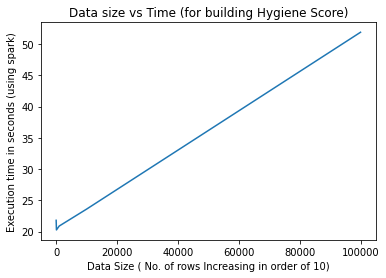

In [ ]:
import matplotlib.pyplot as plt

# plotting the points
plt.plot(x, y)
plt.xlabel('Data Size ( No. of rows Increasing in order of 10)')
plt.ylabel('Execution time in seconds (using spark)')

plt.title('Data size vs Time (for building Hygiene Score)')
plt.show()

In [ ]:
x = []
y = []
for size in datasizes:
  t1 = time.perf_counter()

  data, config, weightage = generateSyntheticDataQ4(size)
  ans = self_sustain_scoreQ1(States, data)

  t2 = time.perf_counter()
  print('Size :',size, ' time taken to run:',t2-t1, 'seconds')
  x.append(size)
  y.append(t2-t1)

Size : 10  time taken to run: 8.428891378999992 seconds
Size : 100  time taken to run: 7.863051526999925 seconds
Size : 1000  time taken to run: 8.225302520000014 seconds
Size : 10000  time taken to run: 9.57886074999999 seconds
Size : 100000  time taken to run: 25.427549109000097 seconds


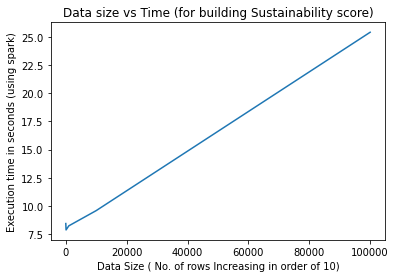

In [ ]:

# plotting the points
plt.plot(x, y)
plt.xlabel('Data Size ( No. of rows Increasing in order of 10)')
plt.ylabel('Execution time in seconds (using spark)')

plt.title('Data size vs Time (for building Sustainability score)')
plt.show()

**END**